In [234]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, fig4_plotting_colours
from utils.post_processing_utils import get_all_experimental_records
from utils.plotting_visuals import makes_plots_pretty
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm
from utils.plotting import output_significance_stars_from_pval

In [178]:
def shift_respecting_index(vals_to_shift, shift_size):
    """
    Shifts a pandas df column by shift_size indices
    but if there is a discontinuity in the index,
    replaces the shifted index with nan
    """
    
    shifted_vals = vals_to_shift.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = vals_to_shift.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > shift_size
    shifted_vals[discontinuities] = np.nan

    return shifted_vals


In [229]:
def perfrom_single_lag_regression(all_session_data, lag):
    all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
    all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
    all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])

    # Define the dependent variable (dopamine response size)
    test_var = f'choice_t_minus_{lag}'


    contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                     & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                    & (all_session_data['First choice correct'] == 1)]
    df = contra_trials[['APE_peaks', test_var]].copy()
    df.loc[:, test_var] = df[test_var].astype(float)
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df.loc[:, 'APE_peaks'] = df['APE_peaks'].astype(float)
    df = df.dropna().reset_index(drop=True)


    y = df['APE_peaks'].astype(float)
    X = df[test_var]
    X = sm.add_constant(X)
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    return model.params[1:], model.pvalues[1:]

In [230]:
def regress_previous_choice_same_stim_against_DA(mice, num_lags=5):
    num_mice = len(mice)
    coefs = np.zeros([num_mice, num_lags])
    pvals = np.zeros([num_mice, num_lags])
    for m, mouse in enumerate(mice):
        bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
        all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

        contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
        if contra_side == 1:
            ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
        else:
            ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
        all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

        # Map 'choice' column to 1 and 0
        all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

        for lag in range(1, num_lags + 1):
            coefs[m, lag-1], pvals[m, lag-1] = perfrom_single_lag_regression(all_session_data, lag)
    return coefs, pvals

In [260]:
def plot_sig_stars_multilag(coefs, color, axs):
    second_order_coefs, second_order_pvals = test_for_coef_trend_against_zero_mulit_lag(coefs)
    for lag_num in range(0, len(second_order_coefs)):
        sig_stars = output_significance_stars_from_pval(second_order_pvals[lag_num])
        if sig_stars != 'n.s.':
            if second_order_coefs[lag_num] >= 0:
                y = 0.3
            else:
                y=-0.45
            axs.text(lag_num + 1, y, sig_stars, ha='center', fontsize=12, color=color)
            

In [261]:
def test_for_coef_trend_against_zero_mulit_lag(coefs):
    pvals = []
    slopes = []
    for lag_num in range(0, coefs.shape[1]):
        test = stats.ttest_1samp(coefs.T[lag_num], 0)
        pvals.append(test.pvalue)
        slopes.append(test.statistic)
    return slopes, pvals

In [262]:
def plot_multilag_coefs_accross_mice(recording_site, coefs, axs, color='blue'):
    # Calculate the mean and SEM across axis=0
    mean_coefs = np.mean(coefs, axis=0)
    sem_coefs = stats.sem(coefs, axis=0)

    # Create the x-axis values
    x = (np.arange(mean_coefs.shape[0]) + 1).astype(int)

    # Plot the mean
    axs.plot(x, mean_coefs, label=recording_site, color=color)


    # Plot the shaded error bars using SEM
    axs.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color=color, alpha=0.3, label='')
    plot_sig_stars_multilag(coefs, color, axs)
    # Adding labels and legend
    axs.set_ylabel('Regression coef')
    axs.set_xlabel('Number of trials back')
    axs.set_ylim([-0.5, 0.5])
    plt.legend(frameon=False)


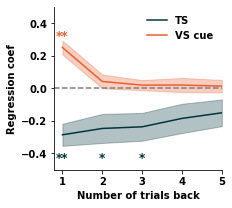

In [263]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
labels = {'tail': 'TS', 'Nacc': 'VS cue'}
for recording_site in ['tail', 'Nacc']:
    mice = change_over_time_mice[recording_site]
    coefs, pvals = regress_previous_choice_same_stim_against_DA(mice)
    plot_multilag_coefs_accross_mice(labels[recording_site], coefs, axs, color=fig4_plotting_colours[recording_site][0])
    makes_plots_pretty(axs)
axs.plot([0.8, 5], [0, 0], ls='--', color='gray')
axs.set_xlim([0.8,5])
axs.xaxis.set_major_locator(MaxNLocator(integer=True))


In [223]:
test_for_coef_trend_against_zero_mulit_lag(coefs)

([5.902299252552355,
  0.9893252118447706,
  0.6195651145453079,
  0.4532307332784791,
  0.3431878308870936],
 [0.0010511222928269192,
  0.36070712983235304,
  0.5583221578403932,
  0.6663118594171523,
  0.7431622361949222])

In [68]:
contra_trials.shape

(130, 36)

In [160]:
import statsmodels.api as sm
mice = change_over_time_mice[recording_site]
num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
        all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                        & (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying 

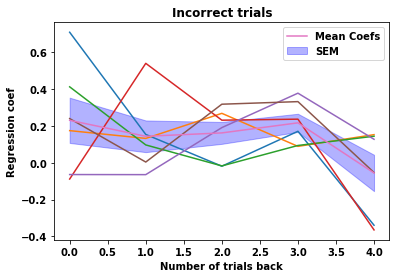

In [161]:
# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0]) 
plt.plot(coefs.T)
# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')

# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.ylabel('Regression coef')
plt.xlabel('Number of trials back')
plt.title('Incorrect trials')
plt.legend()


In [162]:
stats.ttest_1samp(coefs.T[0], 0)

Ttest_1sampResult(statistic=1.8771549716043927, pvalue=0.11931185403916719)

In [163]:
import statsmodels.api as sm

num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = all_session_data['choice'].shift(lag)
        all_session_data[f'stim_t_minus_{lag}'] = all_session_data['Trial type'].shift(lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)]
                                        #& (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on

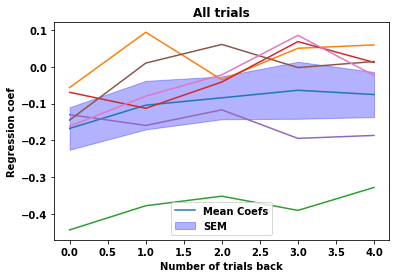

In [164]:
# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0]) 

# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')
plt.plot(coefs.T)
# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.ylabel('Regression coef')
plt.xlabel('Number of trials back')
plt.title('All trials')
plt.legend()

In [165]:
stats.ttest_1samp(coefs.T[0], 0)

Ttest_1sampResult(statistic=-2.9083527305451655, pvalue=0.03346376637415097)